In [51]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [52]:
fileprefix = "full_r_4" # pilot_[1,2,4]
datafolder = '../results/'
filepath = '{}/{}_results.json'.format(datafolder,fileprefix)


In [53]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [54]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        # Update condition here by setting part_object["condition"]
        # print(part_object["condition"])
        # part_object["condition"] = 1
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 63c53d59463365d1a0a23b1e
2 6400d9d7829f8ed06ac31552
3 60eec0367a7cc5ea6ed0e099
4 5d341b57a48ae7000114152a
5 debugDBTy4
6 5ec58f92165cb03f727e520b
7 59aae1188cef7d00011f8884
8 6022dfbafb748f0ca0385db9
9 613f57084e80f056c78f9b7b
10 60f38f94b789eee75b769c34
11 5e7fa0e918b10804bb87eb63
12 5e6ce118673e50000c303890
13 5d0c90dc3382180015624ad9
14 610a545e57efd9a197696c77
15 61196c2c6f63bc62a9eb770a
16 5e152c33814bbab3e0eb7371
17 5c94148a8c4d820001d361d9
18 6091bcc967016811f0f05489
19 615ef30bdf0762beb8b39c54
20 5c58a9908f34eb0001574867
21 602033680babbb6014465aa0
22 5f58c43de85564044e06775f
23 612e9805ed67abf6d38299e1
24 60f5e4c2a0d46e4c6368a816
25 5f53b958c8cfea6e2104c5b6
26 63f93b47bb0c1a1aca131480
27 5dc5da21d999de45a504651b
28 5f5547c3a0ac76108f69e767
29 614e65edaccea7bee04b8ad8
30 5fe848f115b59b69cf9b06b6
31 648028bc524faa07ef0547eb
32 601de190e37c951eaa8c89e4
33 615db0b493aa7174c37cbe78
34 60fbb2b7504ab10991163343
35 57308d1530a5560010ecbc1a
36 6164091188e0c0d34665c821
37 5d960ffd35a7

In [55]:
part_data.keys()


dict_keys(['63c53d59463365d1a0a23b1e', '6400d9d7829f8ed06ac31552', '60eec0367a7cc5ea6ed0e099', '5d341b57a48ae7000114152a', '5ec58f92165cb03f727e520b', '59aae1188cef7d00011f8884', '6022dfbafb748f0ca0385db9', '613f57084e80f056c78f9b7b', '60f38f94b789eee75b769c34', '5e7fa0e918b10804bb87eb63', '5e6ce118673e50000c303890', '5d0c90dc3382180015624ad9', '610a545e57efd9a197696c77', '61196c2c6f63bc62a9eb770a', '5e152c33814bbab3e0eb7371', '5c94148a8c4d820001d361d9', '6091bcc967016811f0f05489', '615ef30bdf0762beb8b39c54', '5c58a9908f34eb0001574867', '602033680babbb6014465aa0', '5f58c43de85564044e06775f', '612e9805ed67abf6d38299e1', '60f5e4c2a0d46e4c6368a816', '5f53b958c8cfea6e2104c5b6', '63f93b47bb0c1a1aca131480', '5dc5da21d999de45a504651b', '5f5547c3a0ac76108f69e767', '614e65edaccea7bee04b8ad8', '5fe848f115b59b69cf9b06b6', '648028bc524faa07ef0547eb', '601de190e37c951eaa8c89e4', '615db0b493aa7174c37cbe78', '60fbb2b7504ab10991163343', '57308d1530a5560010ecbc1a', '6164091188e0c0d34665c821', '5d960ffd

In [6]:
len(part_data.keys())

59

# Reading Data from Already Created Participant Data Files

In [133]:
fileprefix = "full_r" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [134]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [135]:
len(part_data.keys())

409

In [120]:
print(",\n".join(part_data.keys()))

6132735afe304895d5ac6fd3,
5f11eb333c6e2c0df5b92270,
5c50efd2cc71f4000125ce0d,
5bcf6b423a99c40001542fa1,
63e51e063af1cc5baf0c72ca,
61757c0b9a1b784bb12e99c4,
60f946e5de3e8cd2bb450e8d,
616033a44ba802b7e18daaa9,
6167d795d6dd1c505c4e248b,
63b2d04ed0f53f75de4ba38e,
6110e56bd1d45e7a07aacfc8,
62c4590804317dc197ecbe8a,
615d41de9d320ef4a7401c80,
6155841573df9e7e0d71a709,
5cf62554ba314a001b11b8c4,
60da20b656aa7f69fb3d8f6b,
60cce1dff5946c42b4402084,
616d8b61fc7348856d538881,
60bf964f35e4cada9f7f03cc,
6102db96d41a4bf54acd678b,
57618e8a25224a0006d3756e,
5e93138a7d69590115fa1e21,
5bfece626e6cd80001beb6c0,
629f2a1f516a323b811b8273,
6050cb50a965d6a6eb12361e,
60b60d84e30ac4a5e926b7ca,
64e218df1a2b314bcf5c6269,
616cc1c4244b5866081d3f72,
63ef938aea545fb9bd19a591,
5d64426653ba680017d9f63a,
616ad7ac6299f99ce33cdc78,
5c43724ab00b3300018f49bf,
60f118ee4c766f0022d8cad4,
5b39e7a11d4b6800016944d7,
615c1741d4630b25e6bc1cb9,
649ac723cd5ae98d6a7f5f52,
64a2fecad217a7430e1199c4,
613789190e10970db0b4399f,
5b587d897846

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [188]:
# List of participants who are excluded and the reason for exclusion

excluded_parts = []

In [189]:
complete_data.loc[complete_data.workerId == "5c1da6adaaf13200014292cc"]

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
260,5c1da6adaaf13200014292cc,2023-09-01 14:54:50.816948,2023-09-03 04:12:18.837301,2023-09-01 15:11:08.249647,3,chrome,windows,en-US,47848.0,1503.554,...,I found it quite easy.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1916.6,921.378,-582.176,18492.875,0.0


In [190]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except Exception as e:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = int(trial['trialdata']['response']['effort'])
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

613789190e10970db0b4399f
596e1edd39e9d00001b7bb98
596e1edd39e9d00001b7bb98 finishHIT
614395b646280ec3c4ab1d49
614395b646280ec3c4ab1d49 mdp
6159f5208087ddd970d727d1
6159f5208087ddd970d727d1 mdp
60cce1dff5946c42b4402084
60cce1dff5946c42b4402084 mdp
5f5547c3a0ac76108f69e767
5f5547c3a0ac76108f69e767 finishHIT
6137753896c9b6b5813a2432
60f815535ea713f564c6ed61
5b587d897846fa0001fc11c6
5b587d897846fa0001fc11c6 beginning
60da0dd4c8268e2d7125907e
616ed458582d2c3b50149493
5e8c13d8f743d210d47ec874
5e72087440aeca126bf6326c
60dceeaa19d94b7d2651c389
61190367632a534f9e11b013
60f6b8f8e574e14634ead43e
5d0fe250ddf9e30015012fb8
5d0fe250ddf9e30015012fb8 finishHIT
5f97f80e8279d602b5dfd6b1
5f97f80e8279d602b5dfd6b1 finishHIT
5f9aeb04901ce62720fc6838
5c50efd2cc71f4000125ce0d
614209228e118f9a8a39922a
614209228e118f9a8a39922a finishHIT
6365805113952480bdeed7b7
6365805113952480bdeed7b7 finishHIT
615fdd9674ec001e9d325841
6155841573df9e7e0d71a709
6155841573df9e7e0d71a709 mdp
58f669cefb4d7500014af69b
58f669cefb4d75

In [191]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

404


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2293.00,2266.097,1,1.0,40,1291.962,556.90,0,None,True,3,0,True
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,1391.00,1385.727,1,1.0,40,927.627,1498.50,0,finishHIT,False,3,0,True
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,1127.00,1066.054,1,4.0,0,1026.097,0.00,0,mdp,True,3,-1,True
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,1204.00,1182.296,1,4.0,0,896.829,0.00,0,mdp,False,3,-1,True
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,154.42,154.420,0,0.0,0,0.000,0.00,0,mdp,False,6,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2573.00,2381.396,1,1.0,40,1732.595,1127.35,0,None,True,3,0,True
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,1978.00,1967.683,1,1.0,40,1401.213,1830.20,0,None,True,3,0,True
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,1548.00,1534.507,0,1.0,40,893.898,1848.40,0,None,True,3,0,True
402,60e00818b935a41dcfb1cccd,2023-08-31 11:43:11.852818,545.00,525.477,0,1.0,0,394.394,0.00,0,mdp,True,3,-1,False


In [192]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

10


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
8,5b587d897846fa0001fc11c6,2023-09-01 11:38:14.587798,NaT,2023-09-01 11:39:44.292568,6,chrome,windows,en-US,8.267,8.267,...,,{},0,None,True,0.0,0.0,-8.267,NaN,NaN
49,614dd477b69221b863e025af,2023-08-31 11:30:29.015372,NaT,2023-08-31 11:30:42.322420,6,chrome,windows,en-US,21.541,21.541,...,,{},0,None,True,0.0,0.0,-21.541,NaN,NaN
116,5e3421311ddb123e1de9e6ad,2023-08-31 11:49:14.993009,NaT,2023-08-31 11:49:19.921062,6,chrome,windows,en-US,0.000,0.000,...,,{},0,None,True,0.0,0.0,0.000,NaN,NaN
167,615ec038e5541708b1925af2,2023-08-30 09:52:20.745119,NaT,2023-08-30 09:53:18.170167,2,chrome,windows,en-US,71.025,71.025,...,,{},0,None,True,0.0,0.0,-71.025,NaN,NaN
192,60cc72425533320442c05f8c,2023-08-31 11:25:49.761065,NaT,2023-08-31 11:26:01.472389,6,chrome,macos,en-US,47.004,47.004,...,,{},0,None,True,0.0,0.0,-47.004,NaN,NaN
237,6176b584db27cdcecc3896c8,2023-08-30 10:50:35.865442,NaT,2023-08-30 10:50:52.571723,6,chrome,windows,en-GB,15.073,15.073,...,,{},0,None,True,0.0,0.0,-15.073,NaN,NaN
261,613110abdaced6861846c409,2023-08-30 09:49:06.654850,NaT,2023-08-30 09:49:27.548290,6,chrome,windows,en-US,24.198,24.198,...,,{},0,None,True,0.0,0.0,-24.198,NaN,NaN
301,5c8cfc3772503f0001e9c965,2023-09-02 13:11:26.232570,NaT,2023-09-02 13:14:24.049703,6,chrome,windows,en-US,6.606,6.606,...,,{},0,None,True,0.0,0.0,-6.606,NaN,NaN
316,5fad0a601ab00734f83bf339,2023-09-01 10:32:46.676270,NaT,2023-09-01 10:32:57.300988,6,chrome,windows,en-US,35.386,35.386,...,,{},0,None,True,0.0,0.0,-35.386,NaN,NaN
381,6130815ed54ea2aeb63c7eea,2023-08-31 11:15:34.278791,NaT,2023-08-31 11:15:43.354091,6,chrome,windows,en-ZA,48.946,48.946,...,,{},0,None,True,0.0,0.0,-48.946,NaN,NaN


In [193]:
for p in immediate_drops.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [194]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

394


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.00,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.00,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,2023-08-31 11:59:45.882537,2023-08-31 11:41:58.937381,3,chrome,windows,en-US,1127.00,1066.054,...,,{},0,None,True,0.00,1026.097,-39.957,NaN,NaN
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,2023-09-01 15:16:35.861078,2023-09-01 14:56:51.176636,3,chrome,windows,en-US,1204.00,1182.296,...,,{},0,None,True,0.00,896.829,-285.467,NaN,NaN
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,NaT,2023-09-01 11:13:19.965393,6,chrome,linux,en-US,154.42,154.420,...,,{},0,None,True,0.00,0.000,-154.420,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.00,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.00,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.00,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0
402,60e00818b935a41dcfb1cccd,2023-08-31 11:43:11.852818,2023-08-31 11:52:17.006583,2023-08-31 11:43:31.024752,3,chrome,windows,en-ZA,545.00,525.477,...,,{},0,None,True,0.00,394.394,-131.083,NaN,NaN


In [195]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [196]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

8
60cce1dff5946c42b4402084, 0.26 0
6164091188e0c0d34665c821, 1.04 0
613b789d93a4e9a50e6e2c0b, 0.24 1
617678a3559642b86549849d, 0.33 1
616033a44ba802b7e18daaa9, 0.14 0
6050cb50a965d6a6eb12361e, 0.32 1
615d41de9d320ef4a7401c80, 0.25 0
615164a489588e22d2bd33df, 0.08 1


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_97639/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
4,60cce1dff5946c42b4402084,2023-09-01 11:13:02.134156,NaT,2023-09-01 11:13:19.965393,6,chrome,linux,en-US,154.420,154.420,...,{},0,None,True,0.0,0.0,-154.420,NaN,NaN,0.257367
38,6164091188e0c0d34665c821,2023-09-01 14:56:08.916338,NaT,2023-09-01 14:56:42.882223,6,chrome,windows,en-US,623.488,623.488,...,{},0,None,True,0.0,0.0,-623.488,NaN,NaN,1.039147
77,613b789d93a4e9a50e6e2c0b,2023-08-31 11:33:17.833794,NaT,2023-08-31 11:33:30.777947,6,chrome,linux,en-ZA,142.119,142.119,...,{},0,None,True,0.0,0.0,-142.119,NaN,NaN,0.236865
90,617678a3559642b86549849d,2023-08-31 11:25:19.529723,NaT,2023-08-31 11:25:55.382075,6,chrome,linux,en-US,195.499,195.499,...,{},0,None,True,0.0,0.0,-195.499,NaN,NaN,0.325832
209,616033a44ba802b7e18daaa9,2023-09-01 10:48:37.244539,NaT,2023-09-01 10:48:47.157941,6,chrome,android,en-ZA,82.376,82.376,...,{},0,None,True,0.0,0.0,-82.376,NaN,NaN,0.137293
226,6050cb50a965d6a6eb12361e,2023-09-01 10:33:53.279031,NaT,2023-09-01 10:33:59.651877,6,chrome,windows,nl-NL,193.139,193.139,...,{},0,None,True,0.0,0.0,-193.139,NaN,NaN,0.321898
264,615d41de9d320ef4a7401c80,2023-09-01 10:51:15.348343,NaT,2023-09-01 10:51:27.908820,6,chrome,windows,en-ZA,152.799,152.799,...,{},0,None,True,0.0,0.0,-152.799,NaN,NaN,0.254665
326,615164a489588e22d2bd33df,2023-08-31 11:20:41.297174,NaT,2023-08-31 11:20:50.825203,6,chrome,windows,en-US,49.606,49.606,...,{},0,None,True,0.0,0.0,-49.606,NaN,NaN,0.082677


In [197]:
for p in early_quitters.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [221]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))
print(len(failed_quiz.loc[failed_quiz.numQuizAttempts == 4]))

print_all = True

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    if row["numQuizAttempts"] == 4 or print_all:
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

60
17
614395b646280ec3c4ab1d49, 1.71
6159f5208087ddd970d727d1, 1.49
616d8b61fc7348856d538881, 0.38
5adbd63ae0feeb0001ca9865, 0.37
5964ee31b752840001ca4ba4, 0.12
612bef062e4e035e081ba009, 1.30
614dd489fbaaac91b461c640, 4.90
6090755b3aebf491674a5e86, 0.93
616550455f8f691a658e06b0, 1.01
611df548159c59a524111f50, 1.05
6073048f6aaf87a50bfa9787, 0.13
615a0c65241737f2dece4771, 0.28
60ddd06d5358cdcab4a3c82c, 0.29
611d4b7415818acfe3e1857a, 0.19
58f4a7947b2e410001c2edde, 1.68
615ef30bdf0762beb8b39c54, 0.80
6110bd8b78a9ce36185798ab, 2.81
60fc5461ba1ec6f92036ec2c, 1.36
60da20b656aa7f69fb3d8f6b, 0.38
611d83fbcd4d624e50515f20, 0.99
5ae2280338df95000145500c, 0.82
5ff74e9756bc433d405a5773, 0.49
60f70af563ef757f65e750e0, 1.81
63ed50df25d0ea08696b393f, 0.36
60da4e5bdcee7322f9e92817, 0.63
5f1f2a911a2f150d3e011bde, 0.68
611ba9bea0d5bd7db68678e7, 0.64
63039f41fa5c21d483996be2, 1.16
63d13f343d0cb5503347e5ea, 0.18
648f0d5cbe8c028cb2745982, 2.03
61431758d43663d769d89bee, 0.74
615a986463130de77f20ab15, 0.94
5e

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_97639/3546998463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
2,614395b646280ec3c4ab1d49,2023-08-31 11:40:58.212238,2023-08-31 11:59:45.882537,2023-08-31 11:41:58.937381,3,chrome,windows,en-US,1127.000,1066.054,...,{},0,None,True,0.0,1026.097,-39.957,NaN,NaN,1.710162
3,6159f5208087ddd970d727d1,2023-09-01 14:56:31.787421,2023-09-01 15:16:35.861078,2023-09-01 14:56:51.176636,3,chrome,windows,en-US,1204.000,1182.296,...,{},0,None,True,0.0,896.829,-285.467,NaN,NaN,1.494715
28,616d8b61fc7348856d538881,2023-09-01 11:29:16.720192,NaT,2023-09-01 11:29:27.571588,6,chrome,windows,en-GB,421.016,421.016,...,{},0,None,True,0.0,225.097,-195.919,NaN,NaN,0.375162
29,5adbd63ae0feeb0001ca9865,2023-09-02 13:17:59.513914,NaT,2023-09-02 13:18:06.317520,6,chrome,windows,en-GB,329.978,329.978,...,{},0,None,True,0.0,221.699,-108.279,NaN,NaN,0.369498
34,5964ee31b752840001ca4ba4,2023-09-02 13:11:35.844484,NaT,2023-09-02 13:11:43.040552,6,safari,macos,en-GB,200.777,200.777,...,{},0,None,True,0.0,74.848,-125.929,NaN,NaN,0.124747
36,612bef062e4e035e081ba009,2023-08-31 11:33:43.004222,NaT,2023-08-31 11:33:58.680952,6,chrome,windows,en-US,818.395,818.395,...,{},0,None,True,0.0,780.355,-38.040,NaN,NaN,1.300592
39,614dd489fbaaac91b461c640,2023-09-01 10:42:10.779047,2023-09-01 11:45:49.930236,2023-09-01 10:42:28.650091,3,chrome,windows,en-US,3819.000,3800.743,...,{},0,None,True,0.0,2937.600,-863.143,NaN,NaN,4.896000
47,6090755b3aebf491674a5e86,2023-08-31 11:22:46.390417,NaT,2023-08-31 11:23:05.361338,6,chrome,windows,en-US,938.136,938.136,...,{},0,None,True,0.0,555.561,-382.575,NaN,NaN,0.925935
56,616550455f8f691a658e06b0,2023-08-30 09:49:38.651815,NaT,2023-08-30 09:49:50.586214,6,chrome,windows,en-ZA,854.380,854.380,...,{},0,None,True,0.0,603.442,-250.938,NaN,NaN,1.005737
74,611df548159c59a524111f50,2023-09-01 10:37:14.401098,NaT,2023-09-01 10:37:39.111718,6,chrome,windows,en-GB,872.698,872.698,...,{},0,None,True,0.0,629.855,-242.843,NaN,NaN,1.049758


In [199]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
2,614395b646280ec3c4ab1d49,4.0,mdp,0
3,6159f5208087ddd970d727d1,4.0,mdp,0
28,616d8b61fc7348856d538881,2.0,mdp,0
29,5adbd63ae0feeb0001ca9865,2.0,mdp,0
34,5964ee31b752840001ca4ba4,1.0,mdp,0
36,612bef062e4e035e081ba009,2.0,mdp,0
39,614dd489fbaaac91b461c640,4.0,mdp,0
47,6090755b3aebf491674a5e86,1.0,mdp,0
56,616550455f8f691a658e06b0,2.0,mdp,0
74,611df548159c59a524111f50,2.0,mdp,0


In [200]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

614395b646280ec3c4ab1d49	1
6159f5208087ddd970d727d1	1
616d8b61fc7348856d538881	0
5adbd63ae0feeb0001ca9865	1
5964ee31b752840001ca4ba4	1
612bef062e4e035e081ba009	0
614dd489fbaaac91b461c640	0
6090755b3aebf491674a5e86	0
616550455f8f691a658e06b0	1
611df548159c59a524111f50	1
6073048f6aaf87a50bfa9787	0
615a0c65241737f2dece4771	0
60ddd06d5358cdcab4a3c82c	0
611d4b7415818acfe3e1857a	0
58f4a7947b2e410001c2edde	0
615ef30bdf0762beb8b39c54	0
6110bd8b78a9ce36185798ab	0
60fc5461ba1ec6f92036ec2c	1
60da20b656aa7f69fb3d8f6b	1
611d83fbcd4d624e50515f20	1
5ae2280338df95000145500c	1
5ff74e9756bc433d405a5773	0
60f70af563ef757f65e750e0	0
63ed50df25d0ea08696b393f	1
60da4e5bdcee7322f9e92817	1
5f1f2a911a2f150d3e011bde	0
611ba9bea0d5bd7db68678e7	0
63039f41fa5c21d483996be2	1
63d13f343d0cb5503347e5ea	0
648f0d5cbe8c028cb2745982	0
61431758d43663d769d89bee	1
615a986463130de77f20ab15	1
5edd4c9516627fa5965e746e	1
60f6c87c7efc6a4df1230de9	0
5bbd2bdcf7358a000171636f	0
612493c552963eed123a9dba	1
64971e71ba666687996c6072	0
5

In [201]:
for p in failed_quiz.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "quizfail"
    })

In [202]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

326


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,6166e8f5ac6f9f2f58f5744c,2023-09-01 10:39:45.586474,2023-09-01 11:28:02.895277,2023-09-01 10:40:12.907542,3,chrome,windows,en-US,2897.0,2868.339,...,Slightly difficult. What made it difficult was...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,99.40,1998.614,-869.725,19648.175,0.0
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0


In [203]:
data_actually_complete = ["60dc380c84658bee9d398f7b", "616cc1c4244b5866081d3f72", "60ef2e52a188d9859f92bb58",
                          "5cf62554ba314a001b11b8c4", "6167d795d6dd1c505c4e248b", "615c8fc0e879402ccc07472a"]

In [204]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

18


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
23,6155841573df9e7e0d71a709,15,mdp,False
43,611ceab3c1fd8e1d87f84f27,40,finishHIT,False
54,6016bbe3a28c6014fd3236b8,19,mdp,False
58,61335f0c0d6044240df555f8,16,mdp,False
104,644a340c2e2c194d7343deef,2,mdp,False
114,60daf06339ascaccef1a00932,1,mdp,False
138,60ca6cf4fb84a3c8c377b3ae,26,mdp,False
141,59d9cea2e2762800015eb791,32,mdp,False
151,60f87bd38e923677f4181a1a,40,finishHIT,False
165,5fac2398a5caa5150c900df7,15,mdp,False


In [205]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6155841573df9e7e0d71a709	1
611ceab3c1fd8e1d87f84f27	0
6016bbe3a28c6014fd3236b8	0
61335f0c0d6044240df555f8	0
644a340c2e2c194d7343deef	1
60daf06339ascaccef1a00932	1
60ca6cf4fb84a3c8c377b3ae	1
59d9cea2e2762800015eb791	1
60f87bd38e923677f4181a1a	1
5fac2398a5caa5150c900df7	1
5bcf6b423a99c40001542fa1	1
6110e56bd1d45e7a07aacfc8	1
60cdae5d942a76a98eba611a	0
5e6ce118673e50000c303890	1
6023df50d5c2d7069115de3f	0
64de2358a20af46420e8c1af	0
6124c375109ed10432fa2114	0
5891dd715c15e00001583fbc	1


In [206]:

incomplete_full_compensation_eligible = []
incomplete_partial_compensation_eligible = ["60ca6cf4fb84a3c8c377b3ae"]


In [207]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

1
60ca6cf4fb84a3c8c377b3ae, 1.91


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_97639/550307939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
138,60ca6cf4fb84a3c8c377b3ae,2023-09-01 14:57:27.651815,NaT,2023-09-01 14:57:44.800142,2,chrome,windows,en-ZA,1449.183,1449.183,...,{},0,None,True,559.2,1143.467,-305.716,24885.961538,0.0,1.905778


In [208]:
for p in incomplete_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dataincomplete"
    })

In [209]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

155
153


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,6166e8f5ac6f9f2f58f5744c,2023-09-01 10:39:45.586474,2023-09-01 11:28:02.895277,2023-09-01 10:40:12.907542,3,chrome,windows,en-US,2897.0,2868.339,...,Slightly difficult. What made it difficult was...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,99.40,1998.614,-869.725,19648.175,0.0
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0


In [210]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

613789190e10970db0b4399f	1
596e1edd39e9d00001b7bb98	1
5f5547c3a0ac76108f69e767	1
6137753896c9b6b5813a2432	0
60f815535ea713f564c6ed61	1
60da0dd4c8268e2d7125907e	0
616ed458582d2c3b50149493	0
5e8c13d8f743d210d47ec874	0
5e72087440aeca126bf6326c	1
60dceeaa19d94b7d2651c389	0
61190367632a534f9e11b013	1
60f6b8f8e574e14634ead43e	0
5d0fe250ddf9e30015012fb8	1
5f97f80e8279d602b5dfd6b1	1
5f9aeb04901ce62720fc6838	0
5c50efd2cc71f4000125ce0d	1
614209228e118f9a8a39922a	0
6365805113952480bdeed7b7	0
615fdd9674ec001e9d325841	0
58f669cefb4d7500014af69b	1
60dc380c84658bee9d398f7b	1
610eff018bca56cf0d30624b	1
60f946e5de3e8cd2bb450e8d	0
60cd99f1d0df72833ad4346a	0
6346e10721ce6a0ebc5a5907	1
60e5ae1dabf4db8c1de4c2c4	1
60f38f94b789eee75b769c34	0
61635ae3040c7eba5e61449f	0
6113d1d02fbd58ed15b3c8e0	0
6460f320e8ba103d47ded9d6	1
61686ae36b1ad59181b7a22e	0
605ba57d2842d8291b4afd24	1
6472025f5e1c922497375ce2	0
5d7121a843311c0015753cda	0
5d960ffd35a770001a9a0592	0
60fa9b17c5f485add54e64c8	1
5e674adf46fdb74c79935db0	0
5

In [211]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

308


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,It was not that hard just that I made a little...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,Nothing I can think of.,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"It took me about halfway through the game, so ...","{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,I was happy with my performance after I concen...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,Value of viewing the nodes impacted on the amo...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,6166e8f5ac6f9f2f58f5744c,2023-09-01 10:39:45.586474,2023-09-01 11:28:02.895277,2023-09-01 10:40:12.907542,3,chrome,windows,en-US,2897.0,2868.339,...,Slightly difficult. What made it difficult was...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,99.40,1998.614,-869.725,19648.175,0.0
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,IT WAS RELATIVELY THE SAME THROUGHOUT THE GAME.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,I think it was all random so was difficult and...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,"It wasn't difficult, but anxiety caused me to ...",{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0


In [212]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [213]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,613789190e10970db0b4399f,2023-09-01 10:34:41.245987,2023-09-01 11:12:54.926105,2023-09-01 10:35:08.373130,3,chrome,windows,en-GB,2293.0,2266.097,...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,556.90,1291.962,-974.135,20957.525,0.0,0.463898
1,596e1edd39e9d00001b7bb98,2023-09-02 13:11:42.111633,2023-09-02 13:34:53.571068,2023-09-02 13:11:47.470430,3,chrome,windows,en-GB,1391.0,1385.727,...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1498.50,927.627,-458.100,19076.900,0.0,1.248250
5,5f5547c3a0ac76108f69e767,2023-09-01 14:56:07.733456,2023-09-01 15:22:10.384409,2023-09-01 14:56:13.085700,3,chrome,windows,en,1562.0,1556.968,...,"{'Q0': 'Agree', 'Q1': 'Strongly agree', 'Q2': ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",False,2029.80,1303.539,-253.429,29374.700,0.0,1.690823
6,6137753896c9b6b5813a2432,2023-08-31 12:01:33.467081,2023-08-31 12:35:34.977005,2023-08-31 12:01:43.781823,3,chrome,windows,en-US,2041.0,2030.903,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1300.40,1060.801,-970.102,20680.025,0.0,1.083233
7,60f815535ea713f564c6ed61,2023-08-31 11:16:47.597716,2023-08-31 11:42:45.597376,2023-08-31 11:17:00.252589,3,chrome,windows,en-GB,1557.0,1544.541,...,"{'Q0': 'Disagree', 'Q1': 'Agree', 'Q2': 'Neith...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,1453.25,1100.226,-444.315,21478.950,0.0,1.210557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,6166e8f5ac6f9f2f58f5744c,2023-09-01 10:39:45.586474,2023-09-01 11:28:02.895277,2023-09-01 10:40:12.907542,3,chrome,windows,en-US,2897.0,2868.339,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,99.40,1998.614,-869.725,19648.175,0.0,0.082800
399,61757c0b9a1b784bb12e99c4,2023-09-01 10:41:41.853947,2023-09-01 11:24:35.764124,2023-09-01 10:44:52.678148,3,chrome,windows,en-US,2573.0,2381.396,...,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1127.35,1732.595,-648.801,26871.750,0.0,0.939083
400,60867f15c6327e78242c627c,2023-09-01 10:40:56.556944,2023-09-01 11:13:54.603743,2023-09-01 10:41:05.667962,3,chrome,windows,en-US,1978.0,1967.683,...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1830.20,1401.213,-566.470,28038.175,0.0,1.524557
401,61601e9a6b8306196d2a129c,2023-08-31 11:27:40.207915,2023-08-31 11:53:29.180985,2023-08-31 11:27:53.079238,3,chrome,windows,en-ZA,1548.0,1534.507,...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",True,1848.40,893.898,-640.609,16737.650,0.0,1.539717


In [214]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [215]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


613789190e10970db0b4399f, 0.46
596e1edd39e9d00001b7bb98, 1.25
5f5547c3a0ac76108f69e767, 1.69
6137753896c9b6b5813a2432, 1.08
60f815535ea713f564c6ed61, 1.21
616ed458582d2c3b50149493, 1.94
5e8c13d8f743d210d47ec874, 1.30
5e72087440aeca126bf6326c, 1.10
60dceeaa19d94b7d2651c389, 0.49
61190367632a534f9e11b013, 1.67
60f6b8f8e574e14634ead43e, 1.88
5d0fe250ddf9e30015012fb8, 0.54
5f97f80e8279d602b5dfd6b1, 1.95
5f9aeb04901ce62720fc6838, 0.45
614209228e118f9a8a39922a, 0.12
58f669cefb4d7500014af69b, 1.69
60dc380c84658bee9d398f7b, 1.57
610eff018bca56cf0d30624b, 1.55
60cd99f1d0df72833ad4346a, 1.48
6346e10721ce6a0ebc5a5907, 1.72
60e5ae1dabf4db8c1de4c2c4, 1.37
60f38f94b789eee75b769c34, 1.88
61635ae3040c7eba5e61449f, 0.04
6113d1d02fbd58ed15b3c8e0, 1.12
6460f320e8ba103d47ded9d6, 0.43
61686ae36b1ad59181b7a22e, 0.80
605ba57d2842d8291b4afd24, 0.00
6472025f5e1c922497375ce2, 1.24
5d7121a843311c0015753cda, 0.10
5d960ffd35a770001a9a0592, 1.21
60fa9b17c5f485add54e64c8, 1.76
5e674adf46fdb74c79935db0, 1.86
5f64647e

In [216]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.9442571568181817
0.7550573052566394



Condition: 0
Mean: 35.46260419354839
Std: 12.161289525589138
Median: 33.72638333333334

Condition: 1
Mean: 36.51408126361657
Std: 11.942588183613536
Median: 33.67088333333333


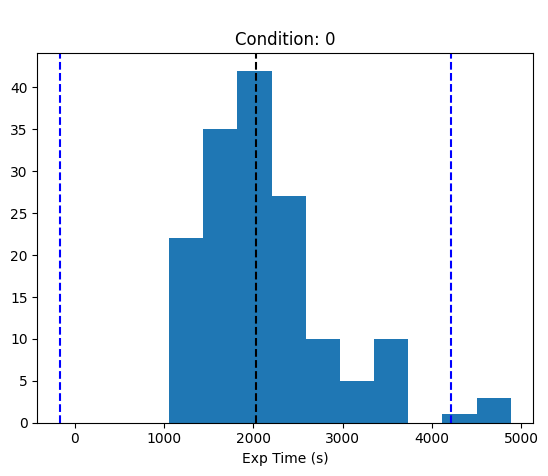

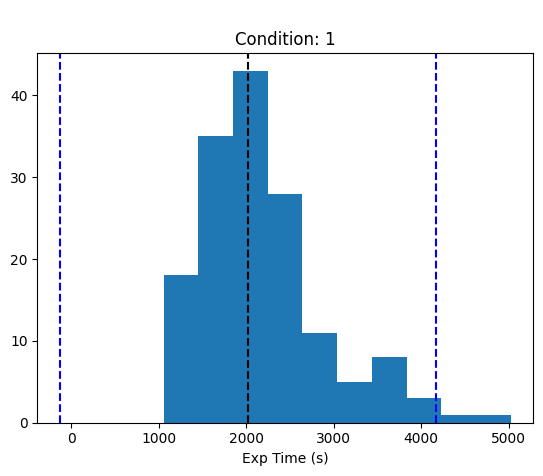

In [217]:
# Time taken per condition

exceeded_parts = []

for condition in [0,1]:
    print("\nCondition: " +str(condition))
    condition_df = complete_data.loc[complete_data.condition == condition]
    clength = condition_df.expLength
    mean = clength.mean()
    sd = clength.std()
    med = clength.median()
    print("Mean: " + str(mean/60))
    print("Std: " + str(sd/60))
    print("Median: " + str(med/60))
    
    time_exceed_df = condition_df.loc[(condition_df.expLength > med + 3*sd) | (condition_df.expLength < med - 3*sd)]
    exceeded_parts += list(time_exceed_df.workerId)
    
    plt.figure()
    plt.hist(clength)
    plt.axvline(med, linestyle='--', color='black')
    plt.axvline(med + 3*sd, linestyle='--', color='blue')
    plt.axvline(med - 3*sd, linestyle='--', color='blue')
    plt.title("\nCondition: " +str(condition))
    plt.xlabel("Exp Time (s)")
    
plt.show()


In [218]:
# Exclude based on time only with full dataset, not with partial dataset
exclude_time = True

In [219]:
# Excluding participants based on time

if exclude_time:
    within_time_parts = complete_data.loc[~complete_data.workerId.isin(exceeded_parts)]
else:
    within_time_parts = complete_data
print(len(within_time_parts.loc[within_time_parts.condition == 0]))
print(len(within_time_parts.loc[within_time_parts.condition == 1]))
print("\n")
for part in exceeded_parts:
    print(part, list(complete_data.loc[complete_data.workerId == part]["condition"])[0])

152
151


60f946e5de3e8cd2bb450e8d 0
5f1bfe98441e2743f34fa16a 0
611e8f65d14fed0d245c6eb4 0
60f5b52aded3aa62d82e5bbb 1
60fbb2b7504ab10991163343 1


In [87]:
if exclude_time:
    for p in exceeded_parts:
        excluded_parts.append({
            "workerId": p,
            "reason": "exceededTime"
        })

In [88]:
# Excluding participants based on effort
ineffortful_parts = within_time_parts.loc[within_time_parts.effort > 1]
ineffortful_parts[["workerId", "condition", "effort"]]


,workerId,condition,effort


In [89]:
effortful_parts = within_time_parts.loc[~within_time_parts.workerId.isin(list(ineffortful_parts.workerId))]
print(len(effortful_parts.loc[effortful_parts.condition == 0]))
print(len(effortful_parts.loc[effortful_parts.condition == 1]))


49
45


In [90]:
for p in ineffortful_parts.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "noeffort"
    })

In [91]:
# Excluding participants who already have done the task
for idx, (workerId, ans) in effortful_parts[["workerId","alreadyParticipated"]].iterrows():
    if "no" not in ans.lower() and "never" not in ans.lower():
        print(workerId, ans)

5ec58f92165cb03f727e520b I didn't participate before
60fbb2b7504ab10991163343 oky
57308d1530a5560010ecbc1a I think I might have done something similar...
60a1ba8693154388bd5273ec Yes
647df23a62de26114fdcb29c I haven't participated in a Web of Cash HIT before. This was my first time.
5ed934569883864994ac0b97 N/A
614324d428b2dd34dce610a5 Yes I realized I had participated in such a game before.
60faab6f9d9a835ba3b8327f yes
60eccd4d9b4a0c1f4ab919a4 The game did seem familiar
5ec96e3609117f0a67231842 This was my first time.
5d7ebf9e93902b0001965912 I don't remember completing it before but have completed a few similar on prolific
6472025f5e1c922497375ce2 This is my first time completing Web of Cash.


In [92]:
# Already participated have to be filtered manually

already_participated_ids = ["60a1ba8693154388bd5273ec","614324d428b2dd34dce610a5","60faab6f9d9a835ba3b8327f"]

already_participated = effortful_parts.loc[effortful_parts.workerId.isin(already_participated_ids)]
already_participated[["workerId", "condition"]]

,workerId,condition
39,60a1ba8693154388bd5273ec,1
83,614324d428b2dd34dce610a5,0
87,60faab6f9d9a835ba3b8327f,1


In [93]:
for p in already_participated.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "alreadyparticipated"
    })

In [94]:
new_parts = effortful_parts.loc[~effortful_parts.workerId.isin(already_participated_ids)]
print(len(new_parts.loc[new_parts.condition == 0]))
print(len(new_parts.loc[new_parts.condition == 1]))

48
43


In [95]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = new_parts.loc[new_parts.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

48
41


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,63c53d59463365d1a0a23b1e,2023-09-01 15:15:20.932542,2023-09-01 15:47:29.361516,2023-09-01 15:15:34.875489,3,chrome,windows,nl-NL,1928.0,1914.0,...,At some point I had a feeling that I was at my...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1739.80,1153.263,-760.737,22512.825,0.0
1,6400d9d7829f8ed06ac31552,2023-09-01 15:31:17.333808,2023-09-01 15:51:21.024895,2023-09-01 15:31:22.422886,3,chrome,windows,en-GB,1203.0,1198.0,...,Not very difficult. Nothing made it particular...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1923.20,913.420,-284.580,19157.425,0.0
2,60eec0367a7cc5ea6ed0e099,2023-09-01 15:35:02.594290,2023-09-01 16:05:29.999027,2023-09-01 15:35:10.611687,3,chrome,macos,en-US,1827.0,1819.0,...,Nothing really. I didnt pay attention on one a...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1535.35,1287.964,-531.036,24036.775,0.0
3,5d341b57a48ae7000114152a,2023-09-01 14:56:21.449462,2023-09-01 16:09:29.320702,2023-09-01 15:32:09.702297,3,chrome,windows,en-GB,4387.0,2239.0,...,N/A - I thought my performance stayed relative...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2064.40,1718.544,-520.456,32948.150,0.0
4,5ec58f92165cb03f727e520b,2023-09-01 14:49:19.209434,2023-09-01 15:28:03.836168,2023-09-01 14:49:29.767868,3,firefox,windows,en-US,2324.0,2314.0,...,I guess it's about concentration and logic but...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,2089.95,1738.135,-575.865,31309.825,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,6472025f5e1c922497375ce2,2023-09-02 13:14:57.917921,2023-09-02 13:50:30.898914,2023-09-02 13:15:16.957444,3,chrome,chromeos,en-GB,2132.0,2113.0,...,The timer made it the most difficult as there ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1486.60,1262.947,-850.053,23182.450,0.0
116,6447a21bdb359b012f49465b,2023-09-02 13:16:27.606045,2023-09-02 13:38:45.541795,2023-09-02 13:16:41.150619,3,chrome,windows,en-US,1337.0,1324.0,...,"Very difficult as it was random, and one point...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-4 to $4', 'Q2': ...",True,1031.60,973.414,-350.586,18114.375,0.0
117,611dfd887f3a8a1fc3f1db46,2023-09-02 13:20:51.494774,2023-09-02 14:09:49.712834,2023-09-02 13:21:12.457091,3,chrome,windows,en-US,2938.0,2917.0,...,first 5 to 10 rounds were little bit difficult...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1261.00,1837.605,-1079.395,25953.050,0.0
118,6396044f6ae489bb820c67a5,2023-09-02 13:25:59.185518,2023-09-02 14:10:08.663984,2023-09-02 13:26:12.259342,3,firefox,windows,en-GB,2649.0,2636.0,...,I found it somewhat difficult to improve my pe...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-258.00,1989.800,-646.200,24920.550,0.0


In [96]:
# Excluding participants

invalid_click_strat_data = new_parts.loc[~new_parts.clickStratsValid]
for p in invalid_click_strat_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "invalidClickStrats"
    })

In [97]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = new_parts.loc[new_parts.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1255.5833333333333
Std: 947.1707404851597
Median: 1487.8

Condition: 1
Mean: 1451.0372093023254
Std: 764.5850430052008
Median: 1652.75

Condition: 2
Mean: nan
Std: nan
Median: nan


In [98]:
# Updating all files of participants whose data should be excluded

for ep in excluded_parts:
    w = ep["workerId"]
    # Get the file name 
    file = [fn for fn in os.listdir(datafolder) if w in fn][0]
    fpath = datafolder + file
    # Read the json
    with open(fpath, 'r') as f:
        participant = json.load(f)
    # Add the fields
    participant["excludeReason"] = ep["reason"]
    # Rewrite the file
    with open(fpath, 'w') as fw:
        json.dump(participant, fw)
    print(f"Wrote to {file}: {ep['reason']}")
    
    

Wrote to full_r_4_5c8cfc3772503f0001e9c965.json: dropout
Wrote to full_r_4_6164091188e0c0d34665c821.json: dropout
Wrote to full_r_4_610a545e57efd9a197696c77.json: quizfail
Wrote to full_r_4_615ef30bdf0762beb8b39c54.json: quizfail
Wrote to full_r_4_614e65edaccea7bee04b8ad8.json: quizfail
Wrote to full_r_4_5d29c671bc573b00165c9014.json: quizfail
Wrote to full_r_4_63039f41fa5c21d483996be2.json: quizfail
Wrote to full_r_4_5964ee31b752840001ca4ba4.json: quizfail
Wrote to full_r_4_6073048f6aaf87a50bfa9787.json: quizfail
Wrote to full_r_4_5edd4c9516627fa5965e746e.json: quizfail
Wrote to full_r_4_60ddd06d5358cdcab4a3c82c.json: quizfail
Wrote to full_r_4_6159f5208087ddd970d727d1.json: quizfail
Wrote to full_r_4_5d49d17b3dad1f0001e2aba1.json: quizfail
Wrote to full_r_4_648f0d5cbe8c028cb2745982.json: quizfail
Wrote to full_r_4_615a0c65241737f2dece4771.json: quizfail
Wrote to full_r_4_611d83fbcd4d624e50515f20.json: quizfail
Wrote to full_r_4_5bbd2bdcf7358a000171636f.json: quizfail
Wrote to full_r_

In [116]:
sorted(list(new_parts.workerId))

['5512eee1fdf99b7e1fb1be40',
 '57618e8a25224a0006d3756e',
 '594abd98215cbd000146debc',
 '5bc35acbe5fc0200012ab7c1',
 '5bfece626e6cd80001beb6c0',
 '5c37ac66bc6444000133b38e',
 '5c43724ab00b3300018f49bf',
 '5c50efd2cc71f4000125ce0d',
 '5cf62554ba314a001b11b8c4',
 '5d3983cb8580230018bbf15f',
 '5d64426653ba680017d9f63a',
 '5d7121a843311c0015753cda',
 '5dde77287d4595dd82f57b10',
 '5e0e0f1af9e75055f77d4ec8',
 '5e72087440aeca126bf6326c',
 '5e93138a7d69590115fa1e21',
 '5ed023de5416bd0ef79fce34',
 '5ef09df28c610f5ffa1601c9',
 '5f11eb333c6e2c0df5b92270',
 '5f1bfe98441e2743f34fa16a',
 '5f2428a843b54d0008905e34',
 '5f45f6591d2bed2170be6c38',
 '5f4b75ca7f5251735fe9b00a',
 '5f7ec762e9dbb819b8b532c6',
 '5fa44f4fd6ecf103ec1d2546',
 '5fbb9d170045d6d085a9bbbf',
 '60867f15c6327e78242c627c',
 '609101a8a29bc713a6bcdbba',
 '60927707758ca118d00ac04b',
 '609ba07731fd79b734cc614e',
 '60a175ae6556e3a7f22c2923',
 '60abb40fe8824c6f9007faeb',
 '60b60d84e30ac4a5e926b7ca',
 '60b880518b31da36270782eb',
 '60bf964f35e4

# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [88]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [89]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [90]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            if trial_count > 40: 
                print(workerId)
                continue
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1


In [81]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [91]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [69]:
len(complete_data)

88

In [70]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: Nothing was confusing or hard to understand
Already participated: I did not
Comments: The experiment ran smoothly


Feedback: No, the instructions were clear and so was the game.
Already participated: No, it was my first time doing this kind of game, hope to get more soon.
Comments: Can I please receive more games like this, I really enjoyed playing it.


Feedback: no
Already participated: no


Feedback: no i understood ok
Already participated: no i have not done this before
Comments: enjoyable task :)


Feedback: Not particularly, it was fun.
Already participated: I haven't participated in this game before.
Comments: Thank you for letting me participate. 


Feedback: No
Already participated: No, I have not participated before
Comments: N/A


Feedback: NO
Already participated: No I have never participated in Web of Cash HIT before
Comments: I enjoyed the game but was a little bit tricky at first


Feedback: No
Already participated: No
Comments: None


Feedback: no. the instru

In [71]:
# Demographics:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 29.786
		SD: 9.517
		Median: 28.000
		Max: 60.000
		Min: -1.000
	Control:
		Mean: 28.674
		SD: 7.580
		Median: 27.000
		Max: 56.000
		Min: 19.000
	Misaligned:
		Mean: 30.951
		SD: 11.176
		Median: 29.000
		Max: 60.000
		Min: -1.000
Gender stats:
	Overall:
		Male: 30 (35.71%)
		Female: 54 (64.29%)
		Other: 0 (0.00%)
	Control:
		Male: 14 (32.56%)
		Female: 29 (67.44%)
		Other: 0 (0.00%)
	Misaligned:
		Male: 16 (39.02%)
		Female: 25 (60.98%)
		Other: 0 (0.00%)


In [72]:
# Effort:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}


for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    print("\n" + conditions[cond])
    print(sub_df["effort"].value_counts())




Control
effort
0    39
1     4
Name: count, dtype: int64

Misaligned
effort
0    32
1     9
Name: count, dtype: int64


In [73]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: When clicking a node if it had a value of 30 0r more I would head for that on most occasions but would sometimes deviate from this.
How strategy was improved: Yes took more notice of amounts as game progressed.
Difficulty: Because numbers seemed a bit random felt a bit of a guessing game at times.


Strategy Used: I found which end nodes had the highest value and then went towards them
How strategy was improved: At first i struggled guessing randomly but then realised the best option was to find the highest end nodes
Difficulty: it was diffuclt to begin but once i got to grips with the task better i found it easier


Strategy Used: I used the nodes inspector on the nodes which I thought would be my end target to see if I was satisfied with the amount, if it was a decent credit I would head to that node.  I tried to see the value of few a nodes as possible to save the expense
How strategy was improved: I'm not sure I did, if at all only by using th

In [81]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in list(complete_data.workerId): continue
        printed = False
        prop_L1clicks = sum([bool(c) for c in part["clicksL1"]])/len(part["clicksL1"])
        if prop_L1clicks < 0.1: continue
        print("\n", part["workerId"], part["clickStratsValid"], prop_L1clicks)
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


 63f787256fc87f0a297a849c True 0.125



 6137753896c9b6b5813a2432 True 0.1



 5b4e2703995d4e0001093117 True 0.35



 5eb64825c23fbf5300fb5bd9 True 0.3



 616ed458582d2c3b50149493 True 0.125



 5fc00a11268eb941e7d8b066 True 0.125



 6113d1d02fbd58ed15b3c8e0 True 0.775



 6122ba6ef91f0ace90542531 True 0.125



 6103b1577404ce2e3e20ceb1 True 0.2



 616ab139038c7029d826e63b True 0.15



 60fd2fe06849943770465f94 True 0.125



 5f1195fdae9a1601ce9ba2c1 True 0.15



 611d3e4fb9e2cb38be842d00 True 0.175



 60fb1cab39fd626cb9dc093b True 0.7



 611cbdc447871199a422d10f True 0.125



 615f4ddc420b1b75f246a4ec True 0.1



 615f1f19a64adde54a57ba27 True 0.15



 5f003e622ec97b13f2764ec9 True 0.725



 60ebda46268b3e82f52b4dfd True 0.45



 6131023dd3d448c3c1102d67 True 0.225



 615fdd9674ec001e9d325841 True 0.15



 60719da557d8241609b26e83 True 0.425



 6153554048e1825ac1946e84 True 0.425



 6157671b6ca7514f658ed117 True 0.3



 60a50457d02bfc23c02d4717 True 0.

0.42776839794048493


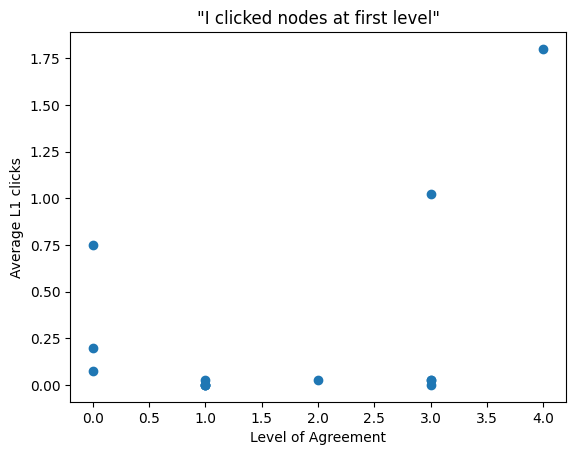

In [61]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



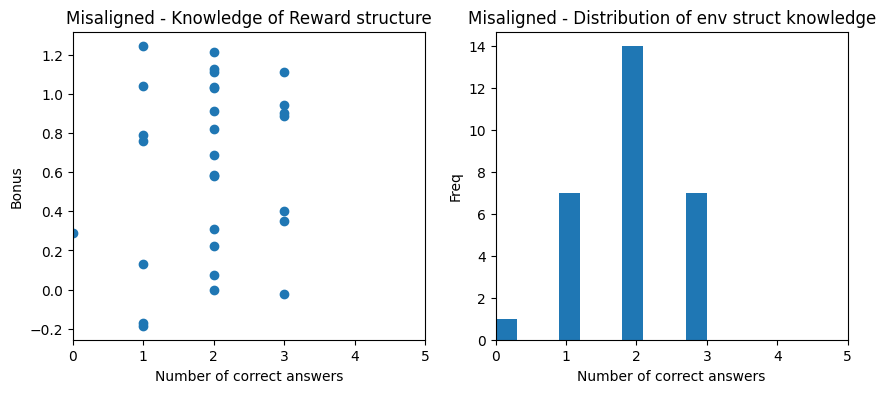

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}